# Exploratory Data Analysis with plotly

In [28]:
import pandas as pd
import pickle
import numpy as np

In [29]:
import plotly.graph_objects as go

In [30]:
file_name = '1308853560411656197.pickle'

In [31]:
file_path = '../data/processed/' + file_name

In [32]:
df = pd.read_pickle(file_path)

In [33]:
df.drop(['id', 'user_id', 'user_name', 'user_description'], axis=1, inplace=True)

In [61]:
df.head(5)

,index,created_at,full_text,user_screen_name,user_location,user_followers_count,retweet_count,favorite_count,lang,processed_text,stemmed,sentiment_score_stemmed,sentiment_score,sent_class,sent_class_stemmed
0,0,2020-09-24 07:13:59,_n1um Eeeewww!!!!come on!!don't do that!!!!,oracle8818,日本,80,0,0,"English, American","[n1um, eeeewww, come]","[n1um, eeeewww, come]",0.0,0.0,neutral,neutral
1,1,2020-09-24 07:13:56,,AureliuszKleks,Agrabah,239,0,0,Undetermined,[],[],0.0,0.0,neutral,neutral
2,2,2020-09-24 07:13:12,This explains so much...,pt_Rexy,"Rio Maior, Portugal",12,0,0,"English, American","[explains, much]","[explain, much]",0.0,0.0,neutral,neutral
3,3,2020-09-24 07:13:05,https://t.co/fP25KvQONY,MrGizo,NaN,3,0,0,Undetermined,[],[],0.0,0.0,neutral,neutral
4,4,2020-09-24 07:13:00,penguin :/ https://t.co/LB1YsCcYwB,LoveHagumiSmile,NaN,34,0,0,Indonesian,[penguin],[penguin],0.0,0.0,neutral,neutral


## Explore

### Language Distribution

The `lang` column of our twitter data is "coded".

We need to convert it to the full name to enhance the reader's experience

We can get a table of all codes and full language name from the website 'https://www.sitepoint.com/iso-2-letter-language-codes/'

This will be scraped into a dictionary object, which we will use to replace coded languages to full name languages.

In [34]:
import requests
import lxml.html as lh

In [35]:
# Scrape from the language code table at the url below
language_code_url = 'https://www.sitepoint.com/iso-2-letter-language-codes/'
r = requests.get(language_code_url)
doc = lh.fromstring(r.content)
# tr elements hold table rows. We can locate them via the xpath.
tr_elements = doc.xpath('//tr')
# Create a list of all the text content for each table row element.
content = [t.text_content() for t in tr_elements]
# Column names are found at content[0], only interested in content (starting at element 1)
# Remove the '\n' padding on the left and right of the string
# Split the string on the '\n' delimiter
parsed_content = [c.lstrip('\n').rstrip('\n').split('\n') for c in content[1:]]
# Unpack the parsed content
k, v = zip(*parsed_content)
# Lower case the code string to match the code in our twitter data.
v = [val.lower() for val in v]
language_dict = {val:key for key, val in zip(k,v)}
language_dict['und'] = 'Undetermined'

In [36]:
df['lang'] = df['lang'].replace(language_dict, regex=True)

**Plot the distribution**

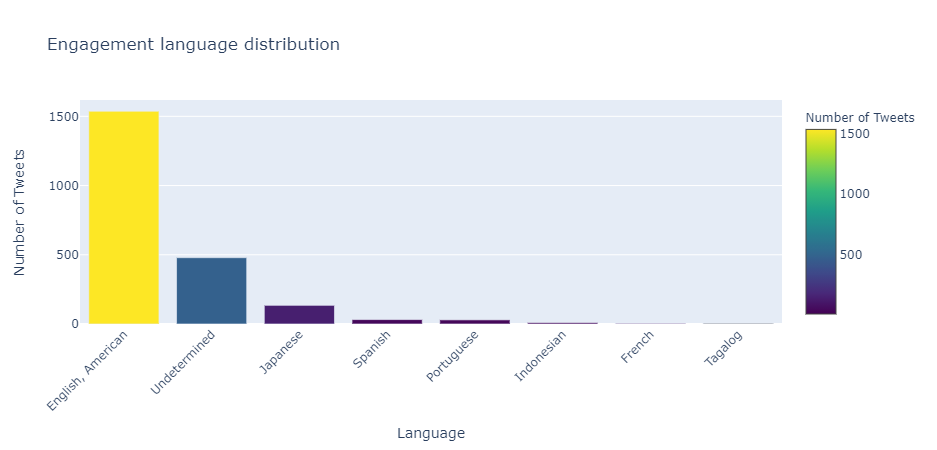

In [56]:
fig = go.Figure(
    data=go.Bar(
        x=df['lang'].value_counts().index[:8],
        y=df['lang'].value_counts().head(8),
        marker=dict(
            colorscale='Viridis',
            color = df['lang'].value_counts().head(7),
            colorbar=dict(
                title='Number of Tweets'
            )
        )
    )
)
fig.update_layout(
    title='Engagement language distribution',
    xaxis_title='Language',
    yaxis_title='Number of Tweets',
    xaxis_tickangle=-45
)
fig.show()

### Sentiment analysis

First, we will look at the distribution of composite sentiment scores. The [vader sentiment intensity analyzer](https://github.com/cjhutto/vaderSentiment) only supports emojis and the English language. We should filter our tweets and only analyse the **English** tweets.

In [108]:
df_en = df[df['lang'].str.contains('English')].reset_index(drop=True).copy()

In [109]:
from plotly.subplots import make_subplots

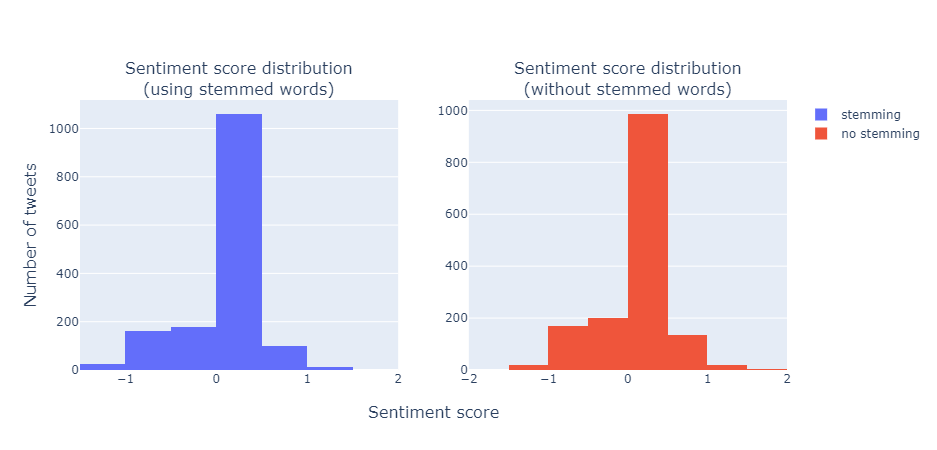

In [110]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        'Sentiment score distribution<br>(using stemmed words)',
        'Sentiment score distribution<br>(without stemmed words)'
    ],
    x_title='Sentiment score',
    y_title='Number of tweets'
)
fig.add_trace(
    go.Histogram(
        x=df_en['sentiment_score_stemmed'],
        name='stemming',
        xbins=dict(
            start=-3.0,
            end=3,
            size=0.5
        )
    ),
        row=1, col=1
)
fig.add_trace(
    go.Histogram(
        x=df_en['sentiment_score'],
        name='no stemming',
        xbins=dict(
            start=-3.0,
            end=3.0,
            size=0.5
        )
    ),
        row=1, col=2
)
fig.show()

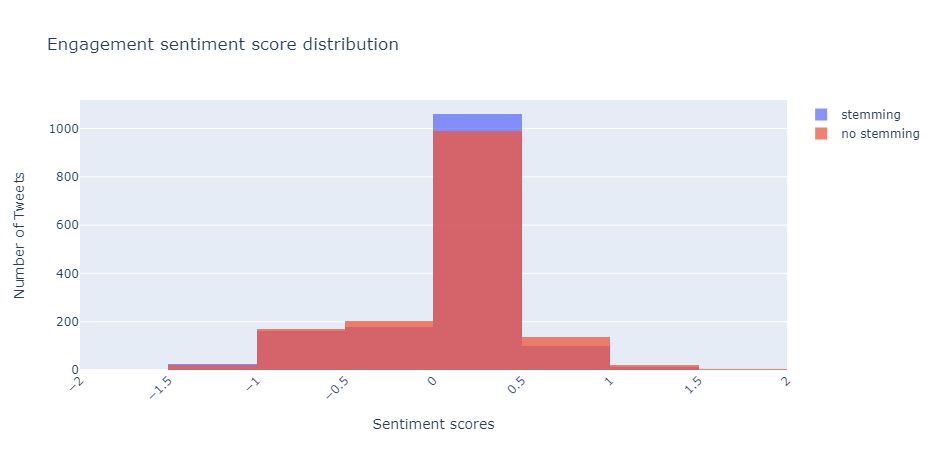

In [171]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=df_en['sentiment_score_stemmed'],
        name='stemming',
        xbins=dict(
            start=-3.0,
            end=3,
            size=0.5
        )
    )
)
fig.add_trace(
    go.Histogram(
        x=df_en['sentiment_score'],
        name='no stemming',
        xbins=dict(
            start=-3.0,
            end=3.0,
            size=0.5
        )
    )
)
fig.update_layout(
    title='Engagement sentiment score distribution',
    xaxis_title='Sentiment scores',
    yaxis_title='Number of Tweets',
    xaxis_tickangle=-45,
    barmode='overlay'
)
fig.update_traces(opacity=0.75)
fig.show()

**The above graph does not clearly distinguish between neutral sentiments and the positive sentiments, although there are indications of a right skew (towards an overall positive sentiment).**

We will look at the categorical interpretations of the above sentiments.

Where:

* **strongly negative** is between -3 and -1.2
* **negative** is between -1.2 and -0.05
* **neutral** is between -0.05 and 0.05
* **positive** is between 0.05 and 1.2
* **strongly postiive** is between 1.2 and 3

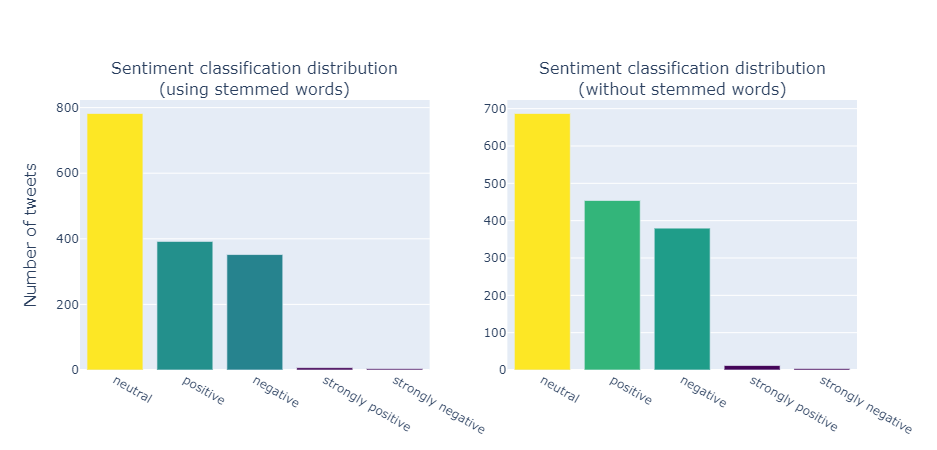

In [111]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        'Sentiment classification distribution<br>(using stemmed words)',
        'Sentiment classification distribution<br>(without stemmed words)'
    ],
    y_title='Number of tweets'
)
fig.add_trace(
    go.Bar(
        x=df_en['sent_class_stemmed'].value_counts().index,
        y=df_en['sent_class_stemmed'].value_counts(),
        marker=dict(
            colorscale='Viridis',
            color = df_en['sent_class_stemmed'].value_counts())
    ),
    row=1, col=1
)
fig.add_trace(
    go.Bar(
        x=df_en['sent_class'].value_counts().index,
        y=df_en['sent_class'].value_counts(),
        marker=dict(
            colorscale='Viridis',
            color = df_en['sent_class'].value_counts())
    ),
    row=1, col=2
)
fig.update_layout(showlegend=False)
fig.show()

We can look more closely at the differences between measuring stemmed/unstemmed tokens for their corresponding sentiments.

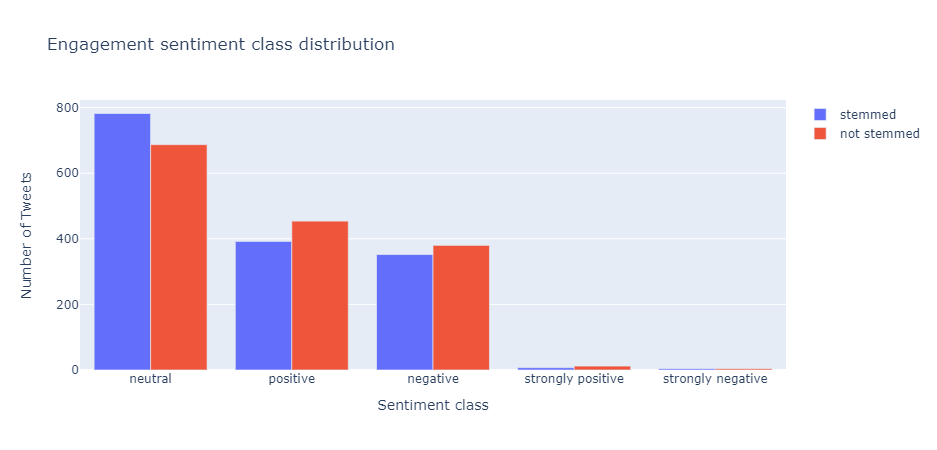

In [177]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=df_en['sent_class_stemmed'].value_counts().index,
        y=df_en['sent_class_stemmed'].value_counts(),
        name='stemmed')      
    )
fig.add_trace(
    go.Bar(
        x=df_en['sent_class'].value_counts().index,
        y=df_en['sent_class'].value_counts(),
        name='not stemmed')
    )
fig.update_layout(
    title='Engagement sentiment class distribution',
    xaxis_title='Sentiment class',
    yaxis_title='Number of Tweets'
)
fig.show()

**As neutral class dominates the other classes, and does not really contribute towards a binary problem (sentiment being positive or negative), we can remove it and just focus on potives and negative classes.**

Filter out the neutral class rows.

In [127]:
df_not_neut = df.drop(df[((df['sent_class_stemmed']=='neutral') | (df['sent_class']=='neutral'))
                ].index, axis=0).reset_index(drop=True).copy()

In [128]:
df_not_neut['sent_class_stemmed'].value_counts()

positive             403
negative             359
strongly positive      7
strongly negative      4
neutral                0
Name: sent_class_stemmed, dtype: int64

**Neutral** class is still listed because the pandas dtype 'categorical' now holds all possible categories even when they do not exist in the dataset.

We shall remove these from `sent_class_stemmed` and `sent_class` columns.

In [129]:
df_not_neut['sent_class_stemmed'].cat.remove_unused_categories(inplace=True)
df_not_neut['sent_class'].cat.remove_unused_categories(inplace=True)

In [130]:
df_not_neut['sent_class_stemmed'].value_counts()

positive             403
negative             359
strongly positive      7
strongly negative      4
Name: sent_class_stemmed, dtype: int64

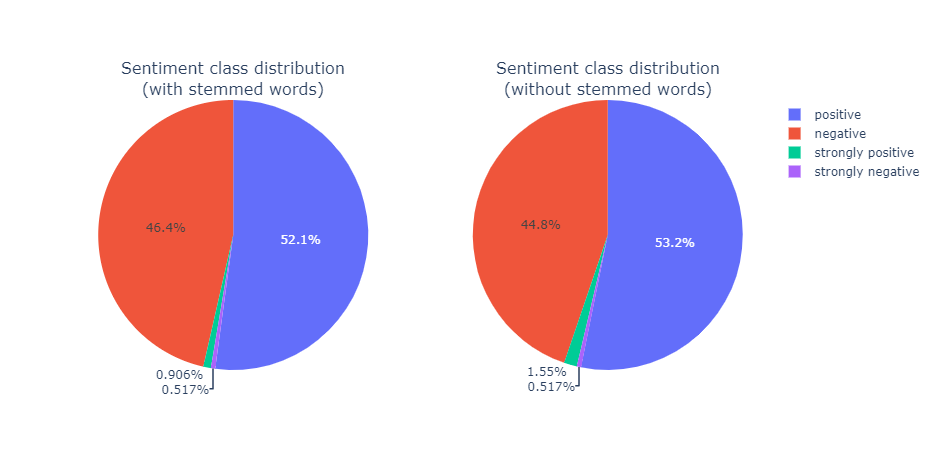

In [140]:
labels = df_not_neut['sent_class_stemmed'].value_counts().index.tolist()
fig = make_subplots(1, 2, specs=[[{'type':'domain'},{'type':'domain'}]],
                    subplot_titles=[
                        'Sentiment class distribution<br>(with stemmed words)',
                        'Sentiment class distribution<br>(without stemmed words)'
                    ])
fig.add_trace(go.Pie(labels=labels, values=df_not_neut['sent_class_stemmed'].value_counts(),
              name='stemmed'), row=1, col=1)
fig.add_trace(go.Pie(labels=labels, values=df_not_neut['sent_class'].value_counts(),
              name='not stemmed'), row=1, col=2)
fig.show()

### Tweet engagement rate

It can be interesting to view engagement numbers over time.

In [142]:
frequencies = ['min', 'H']
engage_freq = [df.groupby([
    pd.Grouper(key='created_at', freq=f)])\
.size()\
.reset_index(name='count')\
.set_index('created_at') for f in frequencies]

engage_freq

[                     count
 created_at                
 2020-09-23 23:25:00      3
 2020-09-23 23:26:00      5
 2020-09-23 23:27:00      6
 2020-09-23 23:28:00      9
 2020-09-23 23:29:00      3
 ...                    ...
 2020-09-24 07:09:00      5
 2020-09-24 07:10:00      7
 2020-09-24 07:11:00      4
 2020-09-24 07:12:00      2
 2020-09-24 07:13:00      5
 
 [469 rows x 1 columns],
                      count
 created_at                
 2020-09-23 23:00:00    245
 2020-09-24 00:00:00    342
 2020-09-24 01:00:00    296
 2020-09-24 02:00:00    247
 2020-09-24 03:00:00    332
 2020-09-24 04:00:00    253
 2020-09-24 05:00:00    253
 2020-09-24 06:00:00    243
 2020-09-24 07:00:00     50]

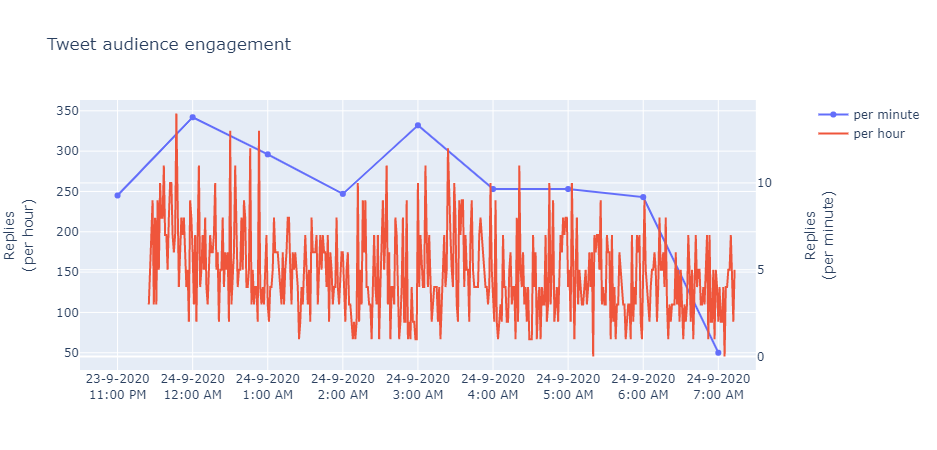

In [164]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
rate = ['per hour', 'per minute']
data = [go.Scatter(x=engage.index, y=engage['count'], name=f) 
        for engage, f in zip(engage_freq, rate)]

fig.add_trace(
    data[1],
    secondary_y=False,
)

fig.add_trace(
    data[0],
    secondary_y=True,
)

fig.update_layout(
    title_text='Tweet audience engagement',
    xaxis_tickformat = '%-d-%-m-%Y<br>%-I:%M %p'
)
fig.update_yaxes(title_text="Replies<br>(per hour)", secondary_y=False)
fig.update_yaxes(title_text="Replies<br>(per minute)", secondary_y=True)

fig.show()

### Popular words

In [173]:
import re
words = df_en['processed_text'].dropna()\
.apply(lambda x: pd.value_counts(re.findall('([\s]\w+[\s])',' '.join(x))))\
.sum(axis=0)\
.to_frame()\
.reset_index()\
.sort_values(by=0, ascending=False)
words.columns = ['word', 'occurences']

In [174]:
words.reset_index(inplace=True, drop=True)
words.head(10)

,word,occurences
0,fall,65.0
1,guys,55.0
2,like,44.0
3,make,24.0
4,game,22.0
5,skeleton,15.0
6,guy,14.0
7,see,13.0
8,mouth,12.0
9,god,12.0


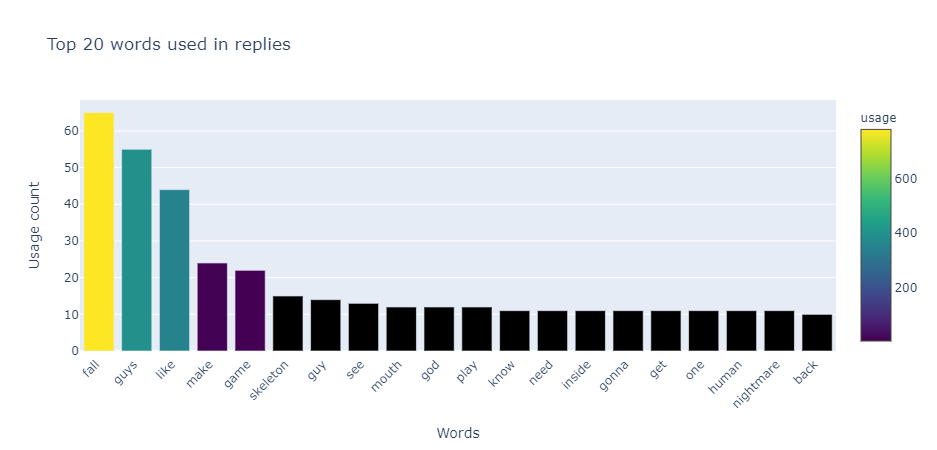

In [180]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=words.head(20)['word'],
        y=words.head(20)['occurences'],
        marker=dict(
            colorscale='Viridis',
            color = df_en['sent_class_stemmed'].value_counts(),
            colorbar=dict(title='usage')
        )
    )
)
fig.update_layout(
    title='Top 20 words used in replies',
    xaxis_title='Words',
    yaxis_title='Usage count',
    xaxis_tickangle=-45
)
fig.show()

### Wordcloud

In [182]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

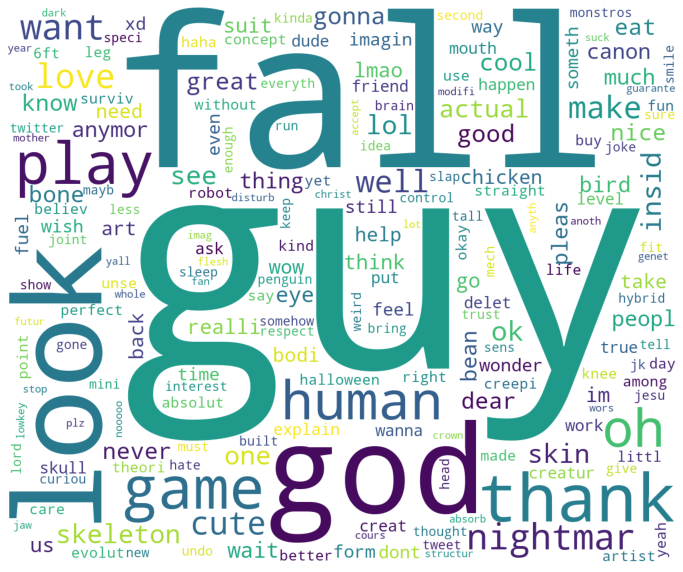

In [183]:
bigstring = df[df['sent_class_stemmed'].str.contains('positive')]['stemmed'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
plt.figure(figsize=(12,12))
wordcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='white',
    collocations=False,
    width=1200,
    height=1000
).generate(bigstring)
plt.axis('off')
plt.imshow(wordcloud)

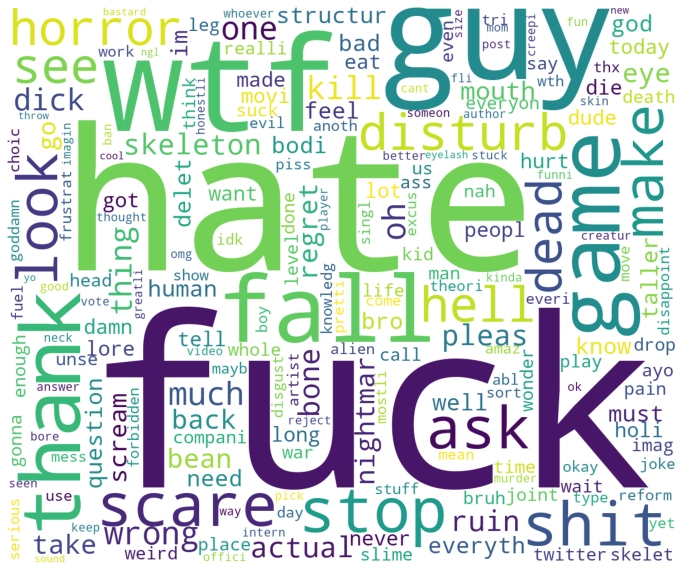

In [184]:
bigstring = df[df['sent_class_stemmed'].str.contains('negative')]['stemmed'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
plt.figure(figsize=(12,12))
wordcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='white',
    collocations=False,
    width=1200,
    height=1000
).generate(bigstring)
plt.axis('off')
plt.imshow(wordcloud)